# Progression Model
This is our model for determining the progression of someone's suicidal tendencies and depression.

## Victoria's Diary
This is a dataset that we will use to train our progression.

Victoria's family made the contents of her diary available to Jesse Bering, a research psychologist at the University of Otago in New Zealand. We scraped exerpts of the diary from Bering's published findings in his book Suicidal: Why We Kill Ourselves.

Applying our model to Victoria's writings allows us to see if our model -- trained on data from online communities -- would generalise well to an unseen test set. In this case, an individual's words.

Using social psychologist Roy Baumeister's theory, Bering mapped different parts of Victoria's diary to six different progressive stages from "falling short of expectations"(stage one) to "high self-awareness"(stage three) to the final stage of "disinhibition". We've matched Bering's findings to each diary exerpt in our dataset.

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
sns.set_style("white")

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [2]:
model_data = pd.read_csv('../data/data_for_model.csv', keep_default_na=False)
vics_diary = pd.read_csv('../data/vics_diary.csv', keep_default_na=False)

In [3]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1897 non-null   object
 1   selftext         1897 non-null   object
 2   author           1897 non-null   object
 3   num_comments     1897 non-null   int64 
 4   is_suicide       1897 non-null   int64 
 5   url              1897 non-null   object
 6   selftext_clean   1897 non-null   object
 7   title_clean      1897 non-null   object
 8   author_clean     1897 non-null   object
 9   selftext_length  1897 non-null   int64 
 10  title_length     1897 non-null   int64 
 11  megatext_clean   1897 non-null   object
dtypes: int64(4), object(8)
memory usage: 178.0+ KB


In [4]:
vics_diary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   vic_detail   62 non-null     object
 1   journ_entry  62 non-null     object
 2   stage        62 non-null     int64 
 3   notes        62 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.1+ KB


In [6]:
vics_diary.shape

(62, 4)

In [7]:
vics_diary.head()

,vic_detail,journ_entry,stage,notes
0,Final Group Text to her friends,"""Love you all, sorry guys.""",0,
1,Letter meant for Grace,"""I just\nwant to say that it has been an hones...",0,
2,Letter meant for Grace,"""If you ever feel\rsad or lonely/' Vic wrote i...",0,
3,no timestamp,"""I don 't want other kids to feel like freaks ...",0,
4,poem,"She laid her head on the pillow beside me,\nFl...",0,


In [8]:
def processing_text(series_to_process):
    new_list = []
    tokenizer = RegexpTokenizer(r'(\w+)')
    lemmatizer = WordNetLemmatizer()
    for i in range(len(series_to_process)):
        # tokenize items
        dirty_string = (series_to_process)[i].lower()
        words_only = tokenizer.tokenize(dirty_string)
        # lemmatize
        words_only_lem = [lemmatizer.lemmatize(i) for i in words_only]
        # removing stop words from lemmatization
        words_without_stop = [i for i in words_only_lem if i not in stopwords.words("english")]
        # return seperated words
        long_string_clean = " ".join(word for word in words_without_stop)
        new_list.append(long_string_clean)
    return new_list

In [11]:
vics_diary["journ_entry_clean"] = processing_text(vics_diary["journ_entry"])
pd.set_option("display.max_colwidth", 100)
vics_diary.head(8)

,vic_detail,journ_entry,stage,notes,journ_entry_clean
0,Final Group Text to her friends,"""Love you all, sorry guys.""",0,,love sorry guy
1,Letter meant for Grace,"""I just\nwant to say that it has been an honest comfort to have someo ne that\nunderstands,"" ""Th...",0,,want say ha honest comfort someo ne understands thank much saving sanity make feel like alone hu...
2,Letter meant for Grace,"""If you ever feel\rsad or lonely/' Vic wrote in a letter to Grace, ""please remember that you are...",0,,ever feel sad lonely vic wrote letter grace please remember living breathing intri cate strong i...
3,no timestamp,"""I don 't want other kids to feel like freaks or teachers to\nalways assume that the kid at the ...",0,,want kid feel like freak teacher always assume kid back class never raise hand shy really paraly...
4,poem,"She laid her head on the pillow beside me,\nFlyaway curls spread across the downy lint,\nHer eye...",0,,laid head pillow beside flyaway curl spread across downy lint eye closed spine convex slim hand ...
5,Suicide note found in her pocket,"""If I'm brain damaged,""\nit read, ""I don't want to be kept alive. I don 't want to be a\nvegetab...",0,,brain damaged read want kept alive want vegetable
6,poem,I snuck a lighter from the kitchen\nWhen I was fifteeni not to smoke: to smell.\nI lit incense s...,0,,snuck lighter kitchen wa fifteeni smoke smell lit incense stick incense stick inhaled sandalwood...
7,poem,Winter Mind - It's a shadow that sweeps over you.\nGrey skies. Charcoal streets coated with grim...,0,,winter mind shadow sweep grey sky charcoal street coated grime glistening wetness rusted lamppos...


In [12]:
vics_diary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   vic_detail         62 non-null     object
 1   journ_entry        62 non-null     object
 2   stage              62 non-null     int64 
 3   notes              62 non-null     object
 4   journ_entry_clean  62 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.5+ KB


In [13]:
# Visualize Data
def TF_IDF_most_used_words(category_string, data_series, palette, image_mask):
    # find most common words
    tvec_optimised = TfidfVectorizer(max_df= 0.5, max_features=70, min_df=2, ngram_range=(1, 3),stop_words = 'english')
    tvec_optimised.fit(data_series)
    # create dataframe
    created_df = pd.DataFrame(tvec_optimised.transform(data_series).todense(),
                              columns=tvec_optimised.get_feature_names())
    total_words = created_df.sum(axis=0)
    
    # create dataframe of top 20 words
    top_20_words = total_words.sort_values(ascending = False).head(20)
    top_20_words_df = pd.DataFrame(top_20_words, columns = ["count"])

    # plotting
    sns.set_style("white")
    plt.figure(figsize = (12, 5), dpi=300)
    ax = sns.barplot(y= top_20_words_df.index, x="count", data=top_20_words_df, palette = palette)
    plt.xlabel("Count", fontsize=9)
    plt.ylabel('Common Words in {}'.format(category_string), fontsize=9)
    plt.yticks(rotation=-5)
    plt.show()

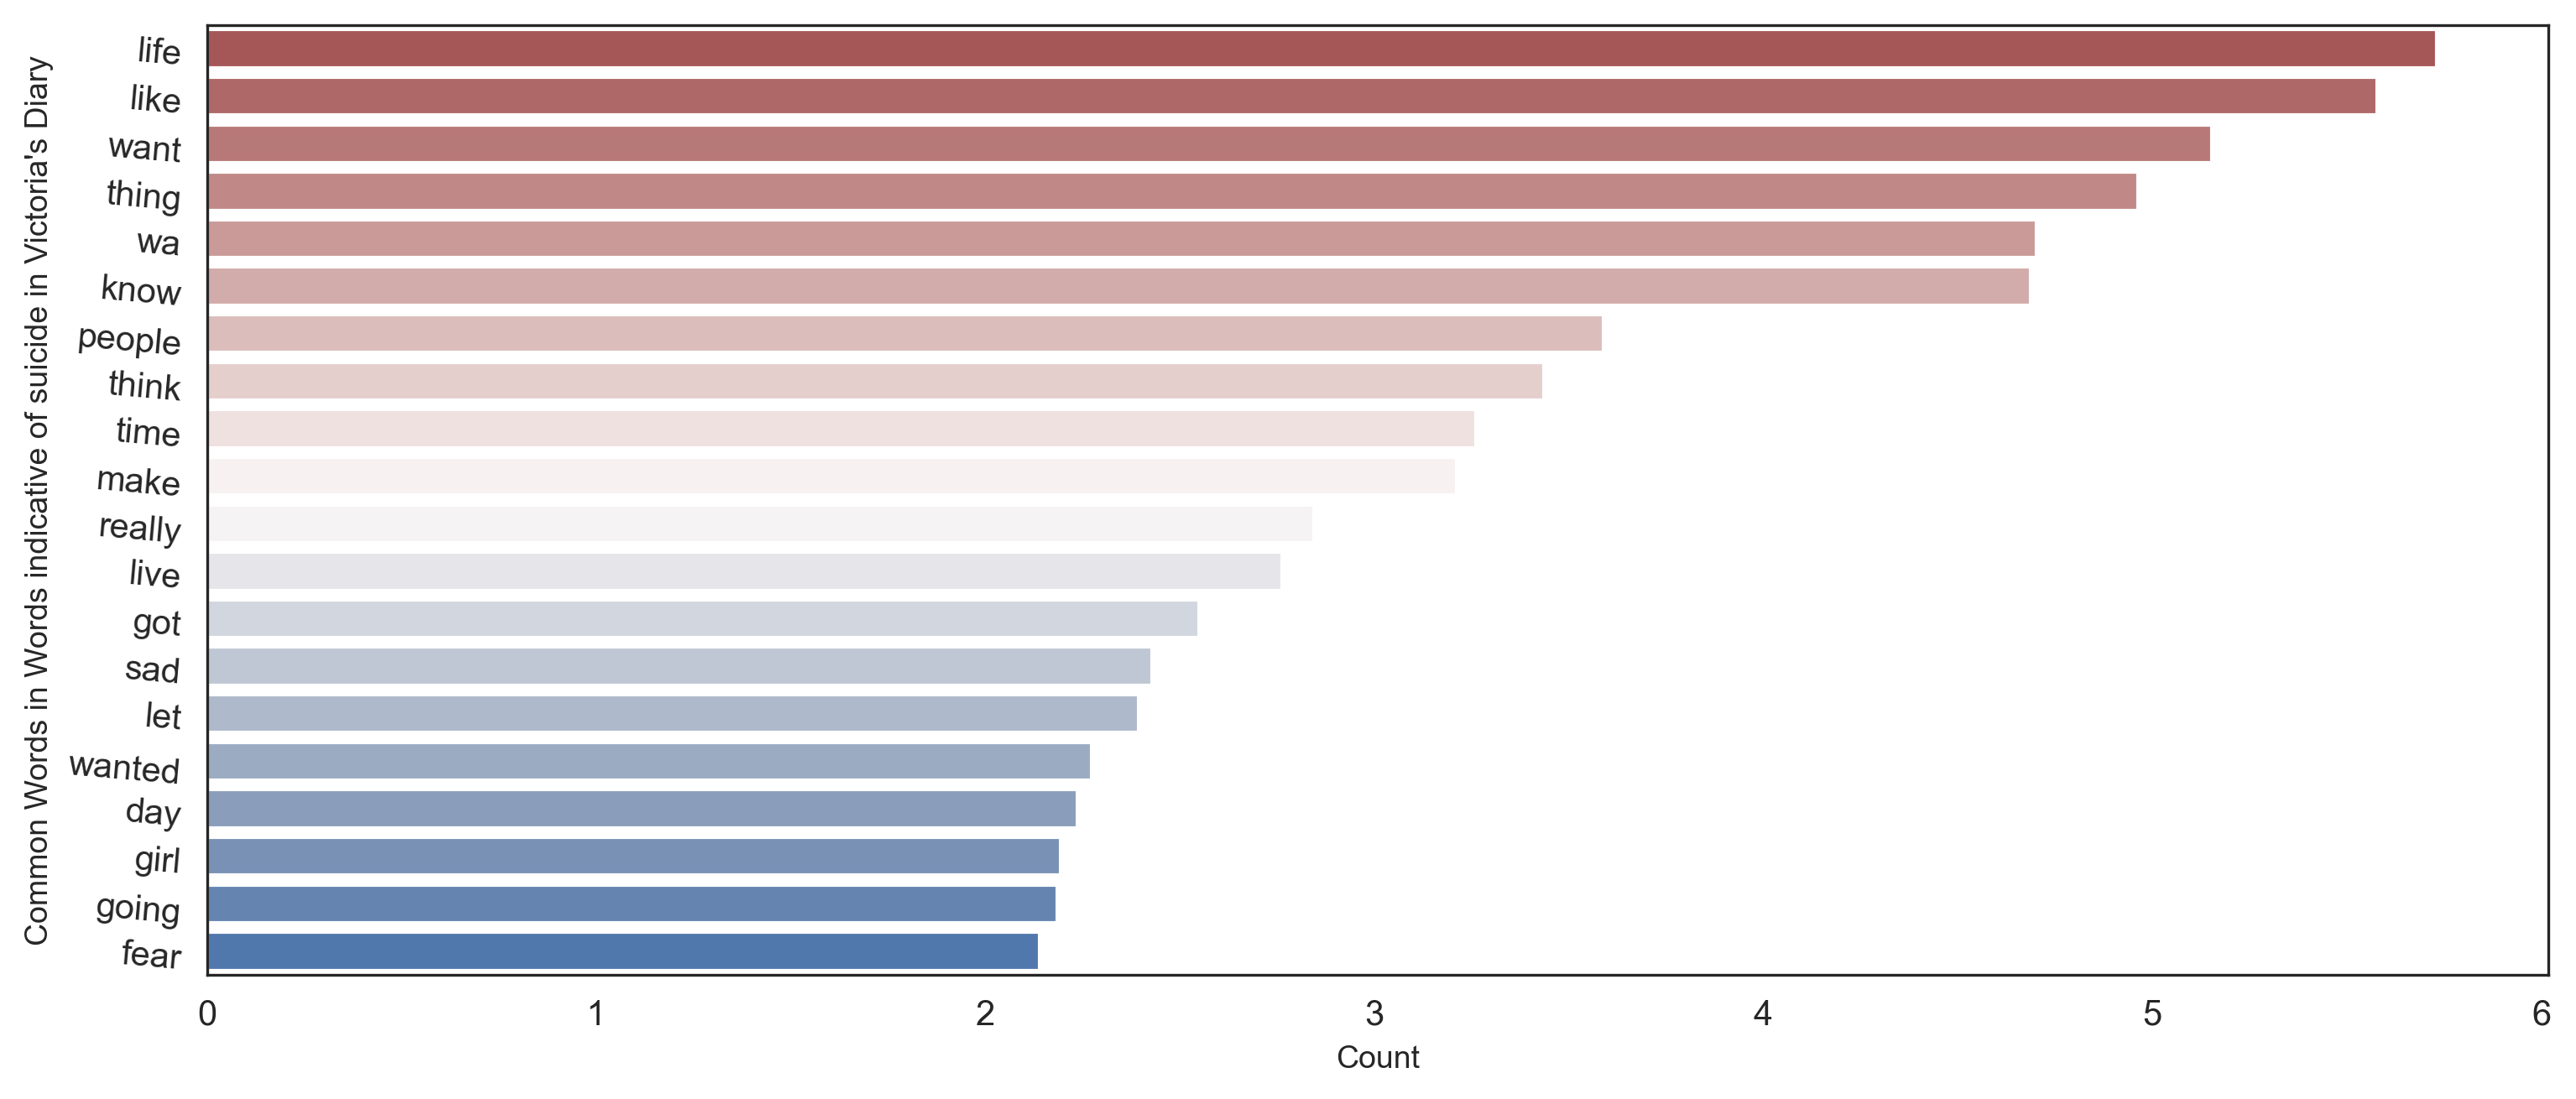

In [16]:
TF_IDF_most_used_words("Words indicative of suicide in Victoria's Diary", vics_diary["journ_entry_clean"], "vlag_r", image_mask="../assets/a_victoria_mask_2.png")

In [17]:
# using model for testing

X_train = model_data["megatext_clean"]
y_train = model_data['is_suicide']

# using the diary as a test set
X_test = vics_diary["journ_entry_clean"]

# fitting vectors
tvec_optimised = TfidfVectorizer(max_df= 0.5, max_features=70, min_df=2, ngram_range=(1, 3),stop_words = 'english')
X_train_tvec = tvec_optimised.fit_transform(X_train).todense()
X_test_tvec = tvec_optimised.transform(X_test).todense()

# fitting MNB Model
nb = MultinomialNB()
nb.fit(X_train_tvec, y_train)

# getting predictions
predictions = nb.predict(X_test_tvec)

# adding predictions to dataframe
vics_diary["predicted_suicide"] = pd.DataFrame(predictions)
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 101)
vics_diary[["journ_entry", "vic_detail", "predicted_suicide" ]].sort_values("vic_detail", ascending=True)

,journ_entry,vic_detail,predicted_suicide
0,"""Love you all, sorry guys.""",Final Group Text to her friends,0
1,"""I just\nwant to say that it has been an honest comfort to have someo ne that\nunderstands,"" ""Thank you so,\nso much for being there and saving my sanity. I just ... you make me\nfeel like I'm not alone, and that's a huge deal.""",Letter meant for Grace,0
2,"""If you ever feel\rsad or lonely/' Vic wrote in a letter to Grace, ""please remember that you are a living,\rbreathing, intri cate, strong, indep endent [person] with the ability to love and\rto laugh and to cry. You have empathy, intelligence and kindnes s, and Grace, you're\rpretty danm awesome...",Letter meant for Grace,0
18,"""We dissolve into a sea of faceless, name less humanity. Just\nanother grownup with no one else to take care of you. When you're\na kid, people genuinely care. You're young . People can't help but feel\nthe need to help you achieve the things they couldn't. When you get\nolder, peop le stop cari...",Stage 1: Falling short of expectations,1
17,"""I never really understood\nthe value of honesty until recently,"" ""It\ncan both heal and destroy you.""",Stage 1: Falling short of expectations,1
16,"Oh the irony. He was a middle-aged guy in a lurid orange shirt and\nhad a kitschy attitude. He told ushowwhen we're sad, we're supposed\nto put a patch on it and move on. I wanted to build a case for myself\nto contradict a lot of things he said. He was simplistic. We all have\nour own ways to c...",Stage 1: Falling short of expectations,0
15,"""I'm not that much of an idiot. There are wor se things than failing\nschool. But when there is nothing else worse than that in your life,\nit's the most terrible thing you can let yourself do:'",Stage 1: Falling short of expectations,0
14,"""If I fail these exams, I know that my\n will be ruined and I can kiss University goodbye.\nI can kiss my life goodbye. All I want is to be a good psychologist.\nI can't do that without a proper degree and a Masters: '",Stage 1: Falling short of expectations,1
13,"I think ( and I know it sounds melodramatic ) that I might not make\nit this year. I know that when I see those grades bold and black on a\npiece of paper - I will either jump for joy, or jump off the top floor of\nthis condo. I know it is absolutely ridiculous to kill yourself because\nyou fail...",Stage 1: Falling short of expectations,1
12,"""I've known that I will never have a\ndazzling life, what with the grades I get ""But if I keep carrying on like this,\n I might actually end up\n.\nsnapping.",Stage 1: Falling short of expectations,1


There are six stages that can be determined in Victoria's diary.

Stage 1: Falling Short of Expectations

Stage 2: Attributions to Self

Stage 3: High Self-Awareness

Stage 4: Negative Affect

Stage 5: Cognitive Deconstruction

Stage 6: Disinhibition

In [18]:
# average predictions
vics_diary["predicted_suicide"].mean()

0.6451612903225806

In [19]:
# checking entries per stage
vics_diary["vic_detail"].value_counts()

Stage 6: Disinhibition                    11
Stage 5: Cognitive Deconstruction         11
Stage 1: Falling short of expectations     8
Stage 4: Negative Affect                   7
Stage 3: High Self-Awareness               7
Stage 2: Attributions to self              7
poem                                       6
Letter meant for Grace                     2
Final Group Text to her friends            1
Suicide note found in her pocket           1
no timestamp                               1
Name: vic_detail, dtype: int64

In [21]:
# plotting predictions per stage
vic_plot_df = pd.DataFrame(vics_diary.groupby("vic_detail")["predicted_suicide"].value_counts())
vic_plot_df.columns = ["counts"]
vic_plot_df = vic_plot_df.reset_index()
vic_plot_df = vic_plot_df.iloc[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,0,1],:]
vic_plot_df

,vic_detail,predicted_suicide,counts
2,Stage 1: Falling short of expectations,1,6
3,Stage 1: Falling short of expectations,0,2
4,Stage 2: Attributions to self,1,6
5,Stage 2: Attributions to self,0,1
6,Stage 3: High Self-Awareness,1,4
7,Stage 3: High Self-Awareness,0,3
8,Stage 4: Negative Affect,1,4
9,Stage 4: Negative Affect,0,3
10,Stage 5: Cognitive Deconstruction,1,8
11,Stage 5: Cognitive Deconstruction,0,3


In [22]:
# Percentage of Entries categorized as Suicidal 
pure_entries_total = vic_plot_df[vic_plot_df["vic_detail"].str.contains("Stage")]["counts"].sum()
pure_entries_predicted_suicide = vic_plot_df[vic_plot_df["vic_detail"].str.contains("Stage")][vic_plot_df[vic_plot_df["vic_detail"].str.contains("Stage")]["predicted_suicide"]==1]["counts"].sum()

pure_entries_predicted_suicide/pure_entries_total


0.7058823529411765

Only about 70 percent of her entries were classified as suicidal, proving how cryptic these messages can be.

In [ ]:
#CREATING A BARPLOT TO VISUALISE HOW THE MODEL CLASSIFIED VICTORIA'S ENTRIES
sns.set_style("white")
colors = ["dark slate blue", "dark red"]  
myPalette = sns.xkcd_palette(colors)
plt.figure(figsize = (15, 10), dpi=300)
plt.title("Classification of entries in Victoria's Diary\n", fontsize=14)
ax = sns.barplot(y='vic_detail', x='counts', data=vic_plot_df, hue='predicted_suicide', palette=myPalette, errwidth=0.01);
plt.ylabel("category of entries");